In [1]:
import os, pickle
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def data_pipe(
            data_path = 'data/Condition_Based_Maintenance.xlsx',
            class_dict = {
                        "Solar Panel": 0,
                        "Charge Controller": 1,
                        "Inverter": 2,
                        "Battery": 3
                    }):
    df = pd.read_excel(data_path)
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['component_type'] = df['component_type'].apply(lambda x: class_dict[x])
    df = df.sort_values(by='DateTime')
    del df['DateTime'], df['fixed_date']
    df = df.dropna()
    
    
    X = df.drop('maintenance_frequency (times/year)', axis=1)
    Y = df['maintenance_frequency (times/year)'] - 1

    return X, Y

In [3]:
X, Y = data_pipe()
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
                                                X, Y, 
                                                test_size=0.2, 
                                                random_state=42
                                                )

print(f"Xtrain shape: {Xtrain.shape}")
print(f"Ytrain shape: {Ytrain.shape}")
print(f"Xtest shape: {Xtest.shape}")
print(f"Ytest shape: {Ytest.shape}")

Xtrain shape: (921, 7)
Ytrain shape: (921,)
Xtest shape: (231, 7)
Ytest shape: (231,)


In [4]:
rfc = RandomForestClassifier(
                            n_estimators=100,
                            max_depth=12
                            )
rfc.fit(X, Y)

RandomForestClassifier(max_depth=12)

In [5]:
with open('artifacts/maintenance.pickle', 'wb') as f:
    pickle.dump(rfc, f)

In [6]:
Ptrain = rfc.predict(Xtrain)
Ptest = rfc.predict(Xtest)

### evaluarion

In [7]:
cls_train = classification_report(
                                Ytrain, 
                                Ptrain,
                                target_names=[
                                            "2 Services",
                                            "3 Services",
                                            "4 Services"
                                            ]
                                )       
cls_test = classification_report(
                                Ytest, 
                                Ptest,
                                target_names=[
                                            "2 Services",
                                            "3 Services",
                                            "4 Services"
                                            ]
                                )   

print("Train Classification Report")
print(cls_train)

print("Test Classification Report")
print(cls_test)

Train Classification Report
              precision    recall  f1-score   support

  2 Services       1.00      1.00      1.00       277
  3 Services       1.00      1.00      1.00       251
  4 Services       1.00      1.00      1.00       393

    accuracy                           1.00       921
   macro avg       1.00      1.00      1.00       921
weighted avg       1.00      1.00      1.00       921

Test Classification Report
              precision    recall  f1-score   support

  2 Services       1.00      0.99      0.99        71
  3 Services       1.00      1.00      1.00        49
  4 Services       0.99      1.00      1.00       111

    accuracy                           1.00       231
   macro avg       1.00      1.00      1.00       231
weighted avg       1.00      1.00      1.00       231



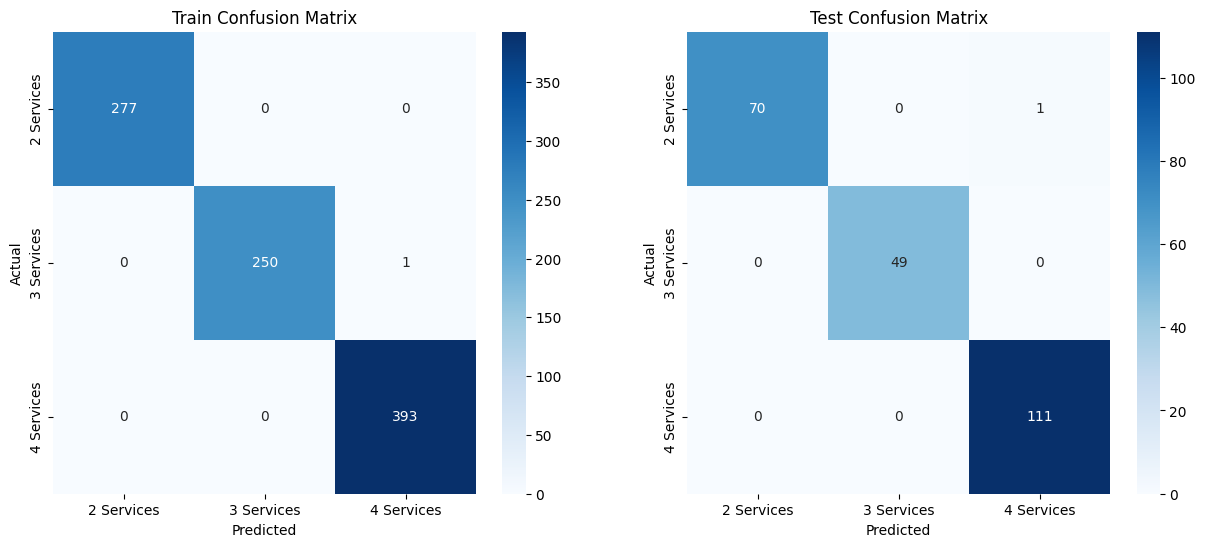

In [8]:
cm_train = confusion_matrix(Ytrain+1, Ptrain+1) 
cm_test = confusion_matrix(Ytest+1, Ptest+1)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=[
                        "2 Services",
                        "3 Services",
                        "4 Services"
                        ],
            yticklabels=[
                        "2 Services",
                        "3 Services",
                        "4 Services"
                        ]
            )
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=[
                        "2 Services",
                        "3 Services",
                        "4 Services"
                        ],
            yticklabels=[
                        "2 Services",
                        "3 Services",
                        "4 Services"
                        ]
            )
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

### inference

In [9]:
with open('artifacts/maintenance.pickle', 'rb') as f:
    rfc = pickle.load(f)

In [10]:
def inference_maintenance(
                        json_data,
                        class_dict = {
                                    "Solar Panel": 0,
                                    "Charge Controller": 1,
                                    "Inverter": 2,
                                    "Battery": 3
                                }
                        ):
    df = pd.DataFrame([json_data])
    df['fixed_date'] = pd.to_datetime(df['fixed_date'])
    df['component_type'] = df['component_type'].apply(lambda x: class_dict[x])
    df = df.dropna()
    df = df.drop('fixed_date', axis=1)
    label = rfc.predict(df)
    label = int(label) + 1
    return f"{label} Services"

In [11]:
sample_json = {
            "component_type":"Battery",
            "fixed_date":1421020800000,
            "ambient_temperature (°C)":24.7902033982,
            "irradiance (W/m²)":598.8113312418,
            "humidity (%)":85.7589222985,
            "device_temperature (°C)":30.3430357589,
            "output_current (A)":11.8643078888,
            "output_voltage (V)":47.713385056
            }

In [12]:
inference_maintenance(sample_json)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18824\625102599.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) + 1


'3 Services'